In [9]:
"""Will mainly follow Brain's Cell paper
GP is trained and validated on wt1-wt2 pairs first
Then wt1-mutant pairs are considered as the "unknown" and need ranking system
For Kd > 10000 nM, the pair is no longer considered as binding
"""
import torch
import esm
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz
from umap import UMAP
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ConstantKernel as C
from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
df = pd.read_hdf('reduced_proteins_embeddings_meta.hdf', key='df')
# concatenate wt1+wt2 and wt1+mut
def concatenate_vectors(row):
    return np.concatenate([row['wild_seq_1_embeddings'], row['wild_seq_2_embeddings']], axis=1)
df['wt1_wt2_concat'] = df.apply(concatenate_vectors, axis=1)
# concatenate wt1+wt2 and wt1+mut
def concatenate_vectors_mut(row):
    return np.concatenate([row['wild_seq_1_embeddings'], row['mutant_seq_embeddings']], axis=1)
df['wt1_mut_concat'] = df.apply(concatenate_vectors_mut, axis=1)
df

,#Pdb,Mutation(s)_PDB,Affinity_mut_parsed,Affinity_wt_parsed,Protein_1,Protein_2,wild_seq_1,wild_seq_2,mutant_seq,specificity_score,wild_seq_1_embeddings,wild_seq_2_embeddings,mutant_seq_embeddings,wt1_wt2_concat,wt1_mut_concat
0,1CSE_E_I,LI45G,5.260000e-11,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...,-3.849387,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.050374627, -0.026959267, 0.027378589, -0.0...","[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
1,1CSE_E_I,LI45S,8.330000e-12,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSD...,-2.006535,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.0537039, -0.024117924, 0.027800042, -0.046...","[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
2,1CSE_E_I,LI45P,1.020000e-07,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPD...,-11.419399,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.05011466, -0.026969189, 0.025009282, -0.05...","[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
3,1CSE_E_I,LI45I,1.720000e-10,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTID...,-5.034166,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.053000774, -0.027996115, 0.027281117, -0.0...","[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
4,1CSE_E_I,LI45D,1.920000e-09,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDD...,-7.446752,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.052454446, -0.025797503, 0.02369322, -0.05...","[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021,2WPT_A_B,FB86A,7.410000e-05,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,-4.503866,"[[0.042925045, 0.06613858, 0.017256295, 0.0520...","[[-0.023957022, -0.03359121, -0.03746649, 0.00...","[[-0.02314554, -0.030065024, -0.04236627, 0.00...","[[0.042925045, 0.06613858, 0.017256295, 0.0520...","[[0.042925045, 0.06613858, 0.017256295, 0.0520..."
2022,2WPT_A_B,"DA33A,FB86A",6.210000e-07,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,0.277973,"[[0.042925045, 0.06613858, 0.017256295, 0.0520...","[[-0.023957022, -0.03359121, -0.03746649, 0.00...","[[-0.02314554, -0.030065024, -0.04236627, 0.00...","[[0.042925045, 0.06613858, 0.017256295, 0.0520...","[[0.042925045, 0.06613858, 0.017256295, 0.0520..."
2023,2WPT_A_B,NA34A,6.490000e-07,8.200000e-07,Colicin E9 DNase,Colicin E2 immunity protein,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MELKHSISDYTEAEFLEFVKKIARAEG

In [4]:
# handle Kd results, first, all Kd is multiplied by 10**9 to be nM, several other modifications:
# 1. any reads > 10000. are converted into 10000.
# 2. if after conversion, mut and wt affinity both have 10000., remove that row (both cases no binding)
# 3. if mut is NaN, wt is 10000., remove that row (both cases no binding)
# 4. if mut is NaN, wt is not 10000., change NaN to 10000. (NaN indicating no binding)
df['Affinity_mut_parsed'] = df['Affinity_mut_parsed'] * (10 ** 9)
df['Affinity_wt_parsed'] = df['Affinity_wt_parsed'] * (10 ** 9)
for col in ['Affinity_mut_parsed', 'Affinity_wt_parsed']:
    df.loc[df[col] > 10000, col] = 10000.
# Drop rows where both columns contain 10000
df = df.drop(df[(df['Affinity_mut_parsed'] == 10000.) & (df['Affinity_wt_parsed'] == 10000.)].index)
# Drop rows where one column is NaN and the other is 10000
df = df.drop(df[((df['Affinity_mut_parsed'].isna()) & (df['Affinity_wt_parsed'] == 10000.)) | ((df['Affinity_wt_parsed'].isna()) & (df['Affinity_mut_parsed'] == 10000.))].index)

# Modify NaN in 'col1' when 'col2' is not 10000, and vice-versa
for col, other_col in [('Affinity_mut_parsed', 'Affinity_wt_parsed'), ('Affinity_wt_parsed', 'Affinity_mut_parsed')]:
    mask = (df[col].isna()) & (df[other_col] != 10000.)
    df.loc[mask, col] = 10000.
df

,#Pdb,Mutation(s)_PDB,Affinity_mut_parsed,Affinity_wt_parsed,Protein_1,Protein_2,wild_seq_1,wild_seq_2,mutant_seq,specificity_score,wild_seq_1_embeddings,wild_seq_2_embeddings,mutant_seq_embeddings,wt1_wt2_concat,wt1_mut_concat
0,1CSE_E_I,LI45G,0.05260,0.00112,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...,-3.849387,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.050374627, -0.026959267, 0.027378589, -0.0...","[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
1,1CSE_E_I,LI45S,0.00833,0.00112,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSD...,-2.006535,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.0537039, -0.024117924, 0.027800042, -0.046...","[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
2,1CSE_E_I,LI45P,102.00000,0.00112,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPD...,-11.419399,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.05011466, -0.026969189, 0.025009282, -0.05...","[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
3,1CSE_E_I,LI45I,0.17200,0.00112,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTID...,-5.034166,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.053000774, -0.027996115, 0.027281117, -0.0...","[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
4,1CSE_E_I,LI45D,1.92000,0.00112,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDD...,-7.446752,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.052454446, -0.025797503, 0.02369322, -0.05...","[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021,2WPT_A_B,FB86A,10000.00000,820.00000,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,-4.503866,"[[0.042925045, 0.06613858, 0.017256295, 0.0520...","[[-0.023957022, -0.03359121, -0.03746649, 0.00...","[[-0.02314554, -0.030065024, -0.04236627, 0.00...","[[0.042925045, 0.06613858, 0.017256295, 0.0520...","[[0.042925045, 0.06613858, 0.017256295, 0.0520..."
2022,2WPT_A_B,"DA33A,FB86A",621.00000,820.00000,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,0.277973,"[[0.042925045, 0.06613858, 0.017256295, 0.0520...","[[-0.023957022, -0.03359121, -0.03746649, 0.00...","[[-0.02314554, -0.030065024, -0.04236627, 0.00...","[[0.042925045, 0.06613858, 0.017256295, 0.0520...","[[0.042925045, 0.06613858, 0.017256295, 0.0520..."
2023,2WPT_A_B,NA34A,649.00000,820.00000,Colicin E9 DNase,Colicin E2 immunity protein,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MELKHSISDYTEAEFLEFVKKIARAEGATECDDAKLVREFERLTEH...,0.233872,"[[-0.023992453, -0.03358702, -0

In [ ]:
max_molar = df[['Affinity_wt_parsed']].median().max()
max_molar

In [6]:
# construct wt training set, remove the duplicated wt1-wt2 entries
dt = df.copy()
dt.drop_duplicates(subset=['wild_seq_1', 'wild_seq_2'], inplace=True)
dt

,#Pdb,Mutation(s)_PDB,Affinity_mut_parsed,Affinity_wt_parsed,Protein_1,Protein_2,wild_seq_1,wild_seq_2,mutant_seq,specificity_score,wild_seq_1_embeddings,wild_seq_2_embeddings,mutant_seq_embeddings,wt1_wt2_concat,wt1_mut_concat
0,1CSE_E_I,LI45G,0.0526,0.00112,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...,-3.849387,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.050374627, -0.026959267, 0.027378589, -0.0...","[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
6,1ACB_E_I,LI45G,45.5000,0.00149,Bovine alpha-chymotrypsin,Eglin c,CGVPAIQPVLSGLSRIVNGEEAVPGSWPWQVSLQDKTGFHFCGGSL...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTGD...,-10.326691,"[[-0.02408382, -0.07500525, 0.095739715, 0.091...","[[0.055853, -0.026456483, 0.03352555, -0.05577...","[[0.0517656, -0.022764446, 0.028771894, -0.046...","[[-0.02408382, -0.07500525, 0.095739715, 0.091...","[[-0.02408382, -0.07500525, 0.095739715, 0.091..."
12,1SBN_E_I,RI45K,0.0320,0.05400,Subtilisin BPN,Eglin c,AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTRD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTKD...,0.523248,"[[-0.026620023, -0.12713915, -0.023718221, 0.1...","[[0.045640845, -0.022037255, 0.03265124, -0.05...","[[0.043771047, -0.02445446, 0.027336929, -0.05...","[[-0.026620023, -0.12713915, -0.023718221, 0.1...","[[-0.026620023, -0.12713915, -0.023718221, 0.1..."
13,1SIB_E_I,KI53R,0.0320,0.11000,Subtilisin BPN,Eglin c,AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...,1.234744,"[[-0.026620023, -0.12713915, -0.023718221, 0.1...","[[0.049512647, -0.024531225, 0.041538414, -0.0...","[[0.05586468, -0.02661387, 0.033568867, -0.055...","[[-0.026620023, -0.12713915, -0.023718221, 0.1...","[[-0.026620023, -0.12713915, -0.023718221, 0.1..."
14,1Y1K_E_I,AI58T,0.0030,0.30000,Subtilisin BPN,Chymotrypsin inhibitor 2,AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...,MKTEWPELVGKSVEEAKKVILQDKPAAQIIVLPVGTIVAMEYRIDR...,MKTEWPELVGKSVEEAKKVILQDKPAAQIIVLPVGTIVAMEYRIDR...,4.605170,"[[-0.02423378, -0.12586969, -0.016004924, 0.14...","[[0.022477234, -0.055314906, 0.017077997, -0.0...","[[0.018416919, -0.06049833, 0.017454382, -0.04...","[[-0.02423378, -0.12586969, -0.016004924, 0.14...","[[-0.02423378, -0.12586969, -0.016004924, 0.14..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008,5UFE_A_B,QB27R,82.4000,50.30000,K-Ras,R11.1.6,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,ATVKFTHQGEEKQVDISKIKWVIRWGQYIWFKYDEDGGAKGWGYVS...,ATVKFTHQGEEKQVDISKIKWVIRWGRYIWFKYDEDGGAKGWGYVS...,-0.493580,"[[0.033050254, -0.0015785629, -0.1265147, -0.0...","[[0.05051038, 0.027671836, -0.011607888, 0.014...","[[0.057605665, -0.03982812, -0.07390956, -0.09...","[[0.033050254, -0.0015785629, -0.1265147, -0.0...","[[0.033050254, -0.0015785629, -0.1265147, -0.0..."
2012,5UFQ_A_C,"DA12G,QC27R,KC59G",82.4000,6.40000,K-Ras,R11.1.6,MTEYKLVVVGADGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,ATVKFTHQGEEKQVDISKIKWVIRWGQYIWFKYDEDGGAKGWGYVS...,ATVKFTHQGEEKQVDISKIKWVIRWGRYIWFKYDEDGGAKGWGYVS...,-2.555287,"[[0.03184991, 0.003854431, -0.122885644, -0.02...","[[0.05051038, 0.027671836, -0.011607888, 0.014...","[[0.06724904, -0.04644814, -0.072430626, -0.10...","[[0.03184991, 0.003854431, -0.122885644, -0.02...","[[0.03184991, 0.003854431, -0.122885644, -0.02..."
2014,5TAR_A_B,"TA183A,KA184E",10000.0000,2300.00000,PDE delta,K-Ras,AKDERAREILRGFKLNWMNLRDAETGKILWQGTEDLSVPGVEHEAR...,GTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,GTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,-4.609509,"[[0.054286197, 0.015738036, 0.044642806, -0.04...","[[0.02156692, -0.015450158, -0.12526123, -0.00...","[[0.02328

In [8]:
train_wt, test_wt = train_test_split(dt[['wt1_wt2_concat', 'Affinity_wt_parsed']], test_size=0.2, random_state=42)
x_train_wt_array = np.vstack(train_wt['wt1_wt2_concat'].to_numpy())
y_train_wt_array = np.vstack(train_wt['Affinity_wt_parsed'].to_numpy())
x_test_wt_array = np.vstack(test_wt['wt1_wt2_concat'].to_numpy())
y_test_wt_array = np.vstack(test_wt['Affinity_wt_parsed'].to_numpy())

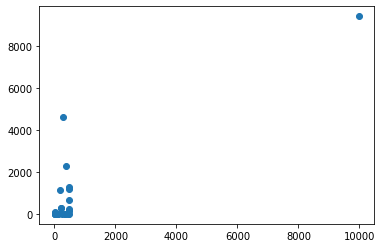

In [10]:
kernel_function = C(10000., 'fixed') * RBF(1., 'fixed')
gpr = GaussianProcessRegressor(kernel=kernel_function, random_state=0, normalize_y=True, copy_X_train=False)
n_samples, n_features = x_train_wt_array.shape
model = gpr.fit(x_train_wt_array, y_train_wt_array)
y_pred_wt, y_var_wt = gpr.predict(x_test_wt_array, return_std=True)
plt.figure()
plt.scatter(y_pred_wt, y_test_wt_array)
plt.show()

In [11]:
import scipy.stats as ss
ss.spearmanr(y_pred_wt, y_test_wt_array)

SpearmanrResult(correlation=0.5489517316395409, pvalue=0.004485807906261104)

In [12]:
ss.pearsonr(y_pred_wt, y_test_wt_array)

(array([0.874771566129521], dtype=object), 1.0758816423215211e-08)

In [14]:
from scipy.stats import rankdata
def acquisition_rank(y_pred, var_pred, beta=1.):
    return rankdata(y_pred) + (beta * rankdata(-var_pred))

In [15]:
# assign ranking and uncertainties
acquisition = acquisition_rank(y_pred_wt, y_var_wt)
acquisition

array([31., 22., 23., 28., 23., 27., 23., 24., 24., 50., 25., 25., 24.,
       28., 23., 29., 25., 24., 25., 22., 25., 24., 26., 25., 25.])

In [16]:
mut = df[['wt1_mut_concat', 'specificity_score']]
unknown_array = np.vstack(mut['wt1_mut_concat'].to_numpy())
unknown_array_y = np.vstack(mut['specificity_score'].to_numpy())
y_pred_mut, y_var_mut = gpr.predict(unknown_array, return_std=True)

In [32]:
unknown_array

array([[-0.03216694, -0.15676358, -0.00066792, ..., -0.2503681 ,
        -0.02919715,  0.02471277],
       [-0.03216694, -0.15676358, -0.00066792, ..., -0.2597928 ,
        -0.03294078,  0.02316579],
       [-0.03216694, -0.15676358, -0.00066792, ..., -0.25935546,
        -0.03007906,  0.02701122],
       ...,
       [-0.02399245, -0.03358702, -0.03738257, ..., -0.05191821,
        -0.03207336,  0.00549663],
       [ 0.04292504,  0.06613858,  0.0172563 , ..., -0.03425744,
         0.01317319,  0.09835219],
       [-0.02399245, -0.03358702, -0.03738257, ..., -0.05191821,
        -0.03207336,  0.00549663]], dtype=float32)

In [17]:
acquisition_unk = acquisition_rank(y_pred_mut, y_var_mut)

In [23]:
def acquisition_scatter(y_unk_pred, var_unk_pred, acquisition):
    y_unk_pred = y_unk_pred[:]
    y_unk_pred[y_unk_pred > 10000] = 10000

    plt.figure()
    plt.scatter(y_unk_pred, var_unk_pred, alpha=0.5, c=-acquisition,
                cmap='hot')
    plt.xlabel('Predicted score')
    plt.ylabel('Variance')
    plt.show()

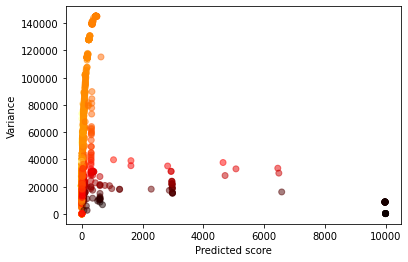

In [24]:
acquisition_scatter(y_pred_mut, y_var_mut, acquisition_unk)

In [ ]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=1).fit(x_train_wt_array)
dist = np.ravel(nbrs.kneighbors(unknown_array)[0])

In [25]:
X = np.vstack([x_train_wt_array, unknown_array])

In [26]:
from umap import UMAP
um = UMAP(
        n_neighbors=15,
        min_dist=0.5,
        n_components=2,
        metric='euclidean',
    )
X_umap = um.fit_transform(X)

In [28]:
from MulticoreTSNE import MulticoreTSNE as TSNE
tsne = TSNE(
        n_components=2,
        n_jobs=20,
    )
X_tsne = tsne.fit_transform(X)

In [33]:
labels = np.concatenate([
        np.zeros(len(x_train_wt_array)), np.ones(len(unknown_array))
    ])
labels

array([0., 0., 0., ..., 1., 1., 1.])

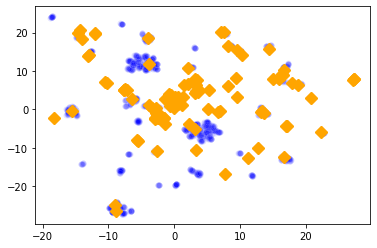

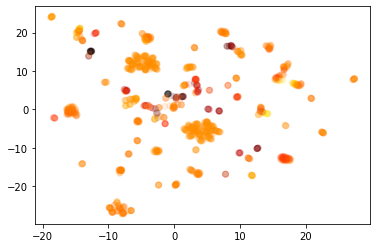

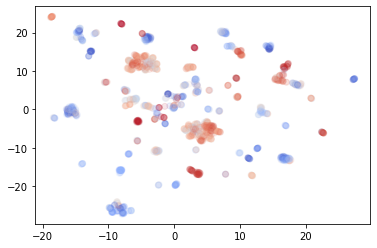

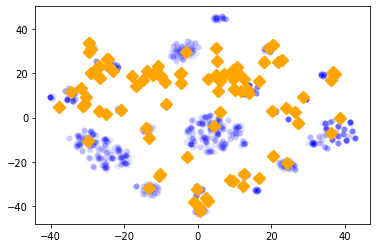

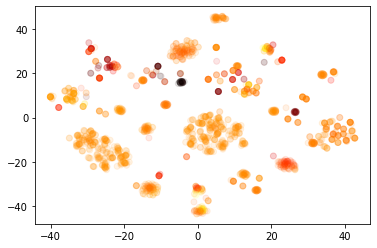

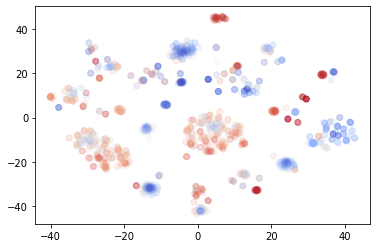

In [37]:
import seaborn as sns
for name, coords in zip(
            ['umap', 'tsne' ],
            [ X_umap, X_tsne ],
    ):
    plt.figure()
    sns.scatterplot(x=coords[labels == 1, 0], y=coords[labels == 1, 1],
                        color='blue', alpha=0.1,)
    plt.scatter(x=coords[labels == 0, 0], y=coords[labels == 0, 1],
                    color='orange', alpha=1.0, marker='x', linewidths=10,)
    plt.figure()
    plt.scatter(x=coords[labels == 1, 0], y=coords[labels == 1, 1],
                    c=-acquisition_unk, alpha=0.1, cmap='hot')
    plt.figure()
    plt.scatter(x=coords[labels == 1, 0], y=coords[labels == 1, 1],
                    c=ss.rankdata(y_var_mut), alpha=0.1, cmap='coolwarm')